# Finding angles with gradient descent

[Michaël Defferrard](https://deff.ch), EPFL LTS2

Notebook showing best practices in TensorFlow v2 to optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_Q(Q_i, Q_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $Q_i$ is a unit quaternion representing a 3D rotation and $d_Q$ is the distance between two rotations.

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

TODO:
* Try to use `tf.data` as input pipeline.
  Should make shuffling, sampling, pre-fetching, caching, batching, and transformations (like computing $d_p$ and adding noise to images) easy.
  Is there a way to make it work like PyTorch datasets?
* Can we use `tf.keras.layers.Embedding` for `angles_predicted`?
* Optimizations (e.g., parallel computations).

In [4]:
from time import time
import h5py
import os

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.geometry.transformation import quaternion

## 1 Data

In [2]:
n_samples = 5000

In [36]:
# location of *.h5 files
data_dir = "../data"

# half coverage (AngCoverage=0.5)
projections_filename = "ProjectionsAngles_ProjNber5000_AngCoverage0.5_AngShift1.57"

# load structures
data = h5py.File(os.path.join(data_dir, f"{projections_filename}.h5"), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (136, 136) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [37]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
angles_true = [quaternion.from_euler(e) for e in angles_true]
print(f'{len(angles_true)} tensors of shape {angles_true[0].shape}')

# Sanity check: the quaternions represent rotations, i.e., are normalized.
#assert abs(tf.reduce_mean(tf.norm(angles_true, axis=2) - tf.ones(n_samples))) < 1e-5

5000 tensors of shape (4,)


In [38]:
# TODO: why isn't this zero? Numerical errors?
# This discrepancy is of the same order as the loss we attain.
tf.reduce_mean(quaternion.relative_angle(angles_true, angles_true))

<tf.Tensor: id=15943072, shape=(), dtype=float64, numpy=1.1944741945686946e-07>

In [39]:
def normalized_random_uniform(quaternion_shape, name=None):
    """Random normalized quaternion following a uniform distribution law on SO(3).
    Args:
    quaternion_shape: A list representing the shape of the output tensor.
    name: A name for this op that defaults to
      "quaternion_normalized_random_uniform".
    Returns:
    A tensor of shape `[quaternion_shape[0],...,quaternion_shape[-1], 4]`
    representing random normalized quaternions.
    """
    with tf.compat.v1.name_scope(name, "quaternion_normalized_random_uniform",
                               [quaternion_shape]):
#         print(quaternion_shape)
        quaternion_shape = tf.convert_to_tensor(value=quaternion_shape,
                                                dtype=tf.int32)
#         print(quaternion_shape)
        quaternion_shape = tf.concat((quaternion_shape, tf.constant([4])), axis=0)
#         print(quaternion_shape)
        random_normal = tf.random.normal(quaternion_shape, dtype=np.float64)
#         print(random_normal)
    return quaternion.normalize(random_normal)

In [32]:
normalized_random_uniform([1])

[1]
tf.Tensor([1], shape=(1,), dtype=int32)
tf.Tensor([1 4], shape=(2,), dtype=int32)
tf.Tensor([[ 0.45155864  0.39558057  0.57754289 -1.06576346]], shape=(1, 4), dtype=float64)


<tf.Tensor: id=15538051, shape=(1, 4), dtype=float64, numpy=array([[ 0.33382029,  0.29243781,  0.4269557 , -0.78787878]])>

In [40]:
# Random initialization.
angles_predicted = [tf.Variable(normalized_random_uniform([1])) for _ in range(n_samples)]
angles_predicted[0]

<tf.Variable 'Variable:0' shape=(1, 4) dtype=float64, numpy=array([[ 0.30637824, -0.30848249, -0.37428336,  0.81907442]])>

## 2 Loss and gradient

In [41]:
def loss(q1_predicted, q2_predicted, distance_target):
    q1 = quaternion.normalize(q1_predicted)
    q2 = quaternion.normalize(q2_predicted)
    distance = quaternion.relative_angle(q1, q2)
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

# Sanity check: zero loss at solution.
distance_target = quaternion.relative_angle(angles_true[0:3], angles_true[1:4])
assert loss(angles_true[0:3], angles_true[1:4], distance_target) < 1e-10

In [44]:
def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
    return loss_value, tape.gradient(loss_value, q1_predicted + q2_predicted)

# Sanity check: zero gradient at solution.
q1 = [tf.Variable(angles_true[i]) for i in [0, 1, 2]]
q2 = [tf.Variable(angles_true[i]) for i in [1, 2, 3]]
distance_target = quaternion.relative_angle(q1, q2)
loss_value, gradients = gradient(q1, q2, distance_target)
assert abs(loss_value) < 1e-5
# assert tf.reduce_all(tf.convert_to_tensor(gradients) < 1e-5 * tf.ones([6, 1, 4]))

## 3 Optimization loop

step 1000/10000 (90s): loss = 1.09e+00
step 2000/10000 (631s): loss = 1.07e+00
step 3000/10000 (710s): loss = 1.00e+00
step 4000/10000 (791s): loss = 9.69e-01
step 5000/10000 (883s): loss = 9.23e-01
step 6000/10000 (973s): loss = 1.04e+00
step 7000/10000 (1065s): loss = 9.26e-01
step 8000/10000 (1155s): loss = 9.69e-01
step 9000/10000 (1244s): loss = 9.65e-01
step 10000/10000 (1336s): loss = 1.00e+00


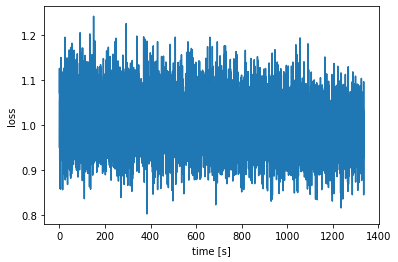

In [43]:
batch_size = 256
steps = 10000

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)


losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1 = list(np.random.randint(0, n_samples, batch_size))
    idx2 = list(np.random.randint(0, n_samples, batch_size))
    q1 = [angles_predicted[i] for i in idx1]
    q2 = [angles_predicted[i] for i in idx2]

    # Compute distances between pairs.
    # To be replaced by distance estimation in pixel space.
    q1_true = [angles_true[i] for i in idx1]
    q2_true = [angles_true[i] for i in idx2]
    distance_target = quaternion.relative_angle(q1_true, q2_true)

    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(q1, q2, distance_target)
    optimizer.apply_gradients(zip(gradients, q1 + q2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [ ]:
# Not a big deal if they're not normalized. Only the direction matters.
# tf.norm(angles_predicted, axis=2)